## 1.generate 2-dimensional data

#### use make_moons generate inital data

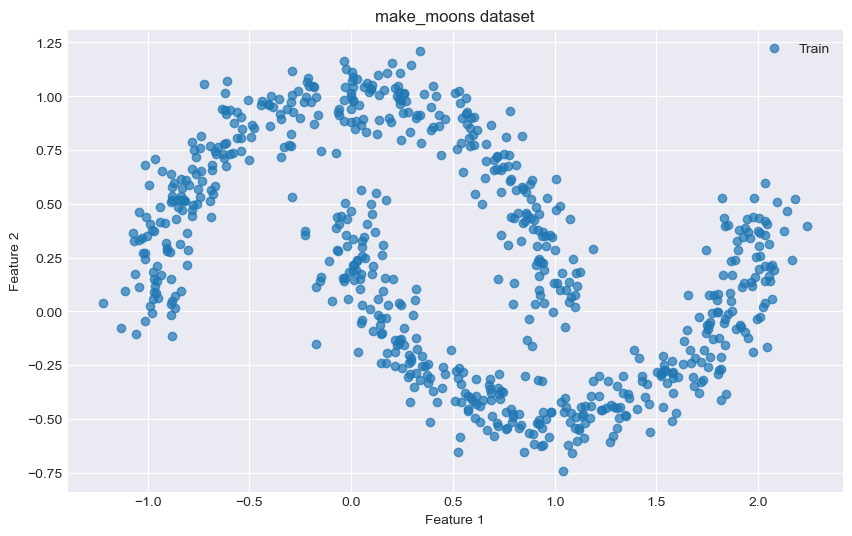

In [1]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from scipy.stats import multivariate_normal 
from matplotlib.patches import Ellipse 
from scipy.spatial.distance import cdist 


plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-v0_8-darkgrid')



# generate dataset
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)  # noise 0.1
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# visualize the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.7, label="Train")
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', alpha=0.8, label="Test")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('make_moons dataset')
plt.legend()
plt.show()


## 2.compare 4 density estimation methods

#### 2.1 Histogram

In [2]:

class Histogram:
    """
    2D histogram density estimation, using IQR-Freedman-Diaconis method to automatically select bin width.
    also support fixed bin number.
    """
    def __init__(self, n_bins=None):
        self.n_bins = n_bins
        self.n_samples = None
        self.bins_x = None
        self.bins_y = None
        self.bin_width_x = None
        self.bin_width_y = None
        self.density_values = None
        self.bin_area = None
        

    def fit(self, X):
        self.X = X
        self.n_samples = X.shape[0]
        
        self._compute_bins(X)
        self._compute_density()

        return self 

    def _compute_bins(self, X):
        # calculate IQR, bin width & bin edges for each dimension
        n =self.n_samples
        if self.n_bins is not None:
            x_min, x_max = X[:,0].min(), X[:,0].max()
            y_min, y_max = X[:,1].min(), X[:,1].max()
            # use fixed number of bins
            self.bins_x = np.linspace(x_min, x_max, self.n_bins+1)
            self.bins_y = np.linspace(y_min, y_max, self.n_bins+1)
            self.bin_width_x = (x_max - x_min) / self.n_bins
            self.bin_width_y = (y_max - y_min) / self.n_bins
            print(f"Using fixed bin number: {self.n_bins} x {self.n_bins}")
        else:
            def _edges(data,n_samples):
                q1, q3 = np.percentile(data, [25, 75])
                iqr = q3 - q1
                h = 2 * iqr / (n_samples ** (1/3))
                if h == 0:
                    h = 1e-5  #divide by zero safeguard

                data_min, data_max = data.min(), data.max()
                # bin number
                M = int(np.ceil((data_max - data_min) / h))

                print(f"Computed bin width: {h}, Number of bins: {M}")
                # edges: M+1 points
                edges = np.linspace(data_min, data_max, M+1)
                return edges, h
            self.bins_x, self.bin_width_x = _edges(self.X[:,0], n)
            self.bins_y, self.bin_width_y = _edges(self.X[:,1], n)

        self.bin_area = self.bin_width_x * self.bin_width_y
        if self.bin_area == 0:
            self.bin_area = 1e-10


    def _compute_density(self):
        # count samples in each bin
        counts, _, _ = np.histogram2d(self.X[:,0], self.X[:,1], bins=[self.bins_x, self.bins_y])
        area = self.bin_width_x * self.bin_width_y
        # probability density (probability per unit area in each bin)
        self.density_values = counts / (self.n_samples * self.bin_area)



    def sample(self, num_samples):
        # sample according to density distribution
        flat_density = self.density_values.flatten()

        flat_density /= flat_density.sum()  # normalize to probability distribution
        chosen_bins = np.random.choice(len(flat_density), size=num_samples, p=flat_density)
        
        
        n_cols = self.density_values.shape[1]
        bin_x_indices = chosen_bins // n_cols
        bin_y_indices = chosen_bins % n_cols


        x_lows = self.bins_x[bin_x_indices]
        x_highs = self.bins_x[bin_x_indices + 1]
        y_lows = self.bins_y[bin_y_indices]
        y_highs = self.bins_y[bin_y_indices + 1]
        sample_x = np.random.uniform(x_lows, x_highs)
        sample_y = np.random.uniform(y_lows, y_highs)

        # return sampled points
        return np.stack([sample_x, sample_y], axis=1)
    


    def density_estimate(self, X):
        # calculate density estimate for given points
        x = X[:, 0]
        y = X[:, 1]

        # np.digitize find bin indices for all points at once
        bin_x_indices = np.digitize(x, self.bins_x) - 1
        bin_y_indices = np.digitize(y, self.bins_y) - 1

        # deal with boundary cases
        num_bins_x = self.density_values.shape[0]
        num_bins_y = self.density_values.shape[1]
        bin_x_indices = np.clip(bin_x_indices, 0, num_bins_x - 1)
        bin_y_indices = np.clip(bin_y_indices, 0, num_bins_y - 1)

        # take density values from precomputed density grid
        densities = self.density_values[bin_x_indices, bin_y_indices]
        
        return densities
    
    def score_samples(self, X):  
        """return log density estimates for given points"""
        densities = self.density_estimate(X)
        return np.log(densities + 1e-10)

    def plot_density(self, X_data=None):
        """
       plot 2D density heatmap (using pcolormesh).
        """
        if self.density_values is None:
            print("must call fit() before plotting.")
            return

        plt.figure(figsize=(8, 6))

        # pcolormesh requires grid edges
        Xgrid, Ygrid = np.meshgrid(self.bins_x, self.bins_y)

        # density_values shape is (M_x, M_y)
        # pcolormesh expects Z to have shape (M_y, M_x), so we use .T
        plt.pcolormesh(Xgrid, Ygrid, self.density_values.T, cmap='viridis', shading='auto')
        plt.colorbar(label='Density Estimate')

        # plot original data points
        if X_data is not None:
            plt.scatter(X_data[:, 0], X_data[:, 1], c='white', s=5, alpha=0.3, label="Data")
            plt.legend()
            
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('2D Histogram Density (IQR-FD Rule)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis('equal')
        plt.show()







#### 2.2 Single Gaussian model

In [3]:
# single Gaussian class

class SingleGaussian:
    """
    Single 2D Gaussian density estimation
    Principle: Fit a 2D normal distribution to all data, and then use the formula to calculate the density at each point.
    """

    def __init__(self):
        self.mu = None  # mean vector
        self.cov = None  # covariance matrix
        self.cov_inv = None  # inverse of covariance matrix
        self.cov_det = None  # determinant of covariance matrix
        self.const = None  # normalization constant
        self.dim = 2  # data dimension




    def fit(self, X):
        """
        Parameters:
            X: training data (n_samples, 2)
        """
        self.dim = X.shape[1]
        self.mu = np.mean(X, axis=0)  # mean (2D)
        self.cov = np.cov(X, rowvar=False)  # covariance matrix (2x2)
        self.cov_inv = np.linalg.inv(self.cov)
        self.cov_det = np.linalg.det(self.cov)
        self.const = 1.0 / (2 * np.pi * np.sqrt(self.cov_det))  # normalization constant
        return self

    def sample(self, num_samples):
        """
        Sample from the fitted Gaussian distribution
        Parameters:
            num_samples: number of samples to draw
        Returns:
            samples: sampled points (num_samples, 2)
        """
        samples = np.random.multivariate_normal(self.mu, self.cov, size=num_samples)
        return samples
    
    def density(self, X):
        """
        Compute the density values for given points
        Parameters:
            X: points to evaluate (n_samples, 2)
        Returns:
            densities: density values (n_samples,)
        """
        X = np.atleast_2d(X)
        diff = X - self.mu  # (n_samples, 2)

        exponent = -0.5 * np.sum(diff @ self.cov_inv * diff, axis=1)  # (n_samples,)
        densities = self.const * np.exp(exponent)
        return densities

    def score_samples(self, X):  
        """return log density estimates for given points"""
        densities = self.density(X)
        return np.log(densities + 1e-10)

    def plot_density(self, X_data=None, n_grid=100):
        """
        Plot the density distribution
        """
        # Generate grid
        x = np.linspace(self.mu[0]-3*np.sqrt(self.cov[0,0]), self.mu[0]+3*np.sqrt(self.cov[0,0]), n_grid)
        y = np.linspace(self.mu[1]-3*np.sqrt(self.cov[1,1]), self.mu[1]+3*np.sqrt(self.cov[1,1]), n_grid)
        Xgrid, Ygrid = np.meshgrid(x, y)
        grid_points = np.c_[Xgrid.ravel(), Ygrid.ravel()]


        densities = self.density(grid_points)
        Z = densities.reshape(Xgrid.shape)
        plt.figure(figsize=(8,6))
        plt.contourf(Xgrid, Ygrid, Z, levels=20, cmap='viridis')
        plt.colorbar(label='Density')

        # Plot original data points
        if X_data is not None:
            plt.scatter(X_data[:, 0], X_data[:, 1], c='white', s=5, alpha=0.3, label="Data")
            plt.legend()


        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Single Gaussian Density Estimate')
        plt.axis('equal')
        plt.show()





#### 2.3 GMM

In [4]:
class GaussianMixtureModel:
    """
   GMM 2D density estimation.use EM algorithm to fit parameters.
    
    """
    def __init__(self, n_components=3, max_iter=100, tol=1e-4):
        """
        Parameters:
            n_components: number of Gaussian components
            max_iter: maximum number of iterations
            tol: convergence threshold
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None  # mixture weights
        self.means = None    # means
        self.covs = None     # covariance matrices

    def _initialize(self, X):
        """Randomly initialize parameters"""
        n_samples, n_features = X.shape

        # Randomly select K points as initial means
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]

        # Initialize covariances as identity matrices
        self.covs = np.array([np.eye(n_features) for _ in range(self.n_components)])
        
        # weights initialized equally
        self.weights = np.ones(self.n_components) / self.n_components
    

    
    def _e_step(self, X):
        """E-step: Compute posterior probabilities (responsibilities)"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            rv = multivariate_normal(self.means[k], self.covs[k])
            responsibilities[:, k] = self.weights[k] * rv.pdf(X)
        
        # normalize
        responsibilities /= responsibilities.sum(axis=1, keepdims=True) + 1e-10
        return responsibilities
    
    def _m_step(self, X, responsibilities):
        """M-step: Update parameters"""
        n_samples, n_features = X.shape
        
        for k in range(self.n_components):
            resp_k = responsibilities[:, k]
            total_resp = resp_k.sum()
            
            # Update weights
            self.weights[k] = total_resp / n_samples
            
            # Update means
            self.means[k] = (resp_k[:, np.newaxis] * X).sum(axis=0) / total_resp
            
            # update covariances
            diff = X - self.means[k]
            self.covs[k] = (resp_k[:, np.newaxis] * diff).T @ diff / total_resp

            # Add regularization to prevent singular matrix
            self.covs[k] += np.eye(n_features) * 1e-6
    
    def _compute_log_likelihood(self, X):
        """Compute log likelihood"""

        # p(X) = [p(x_1), p(x_2), ..., p(x_n)]
        densities = self.density(X)
        # log p(X) = [log p(x_1), ..., log p(x_n)]
        log_likelihoods = np.log(densities + 1e-10)
        
        # L = sum( log p(x_n) )
        return np.sum(log_likelihoods)
    
    def fit(self, X):
        """
        Train the model (EM algorithm)

        Parameters:
            X: training data (n_samples, 2)
        """
        self._initialize(X)
        
        log_likelihood_old = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self._e_step(X)
            
            # M-step
            self._m_step(X, responsibilities)
            
            # calculate log likelihood
            log_likelihood = self._compute_log_likelihood(X)
            
            # check convergence
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                print(f"GMM convergence at {iteration + 1}")
                break
            
            log_likelihood_old = log_likelihood
        
        return self
    
    def density(self, X):
        """
        Compute the density values for the samples

        Parameters:
            X: sample data (n_samples, 2)

        Returns:
            density: density values
        """
        X = np.atleast_2d(X)
        n_samples = X.shape[0]
        # Initialize component densities
        component_densities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            # Compute the density for each component
            rv = multivariate_normal(self.means[k], self.covs[k])
            component_densities[:, k] = rv.pdf(X)

        weighted_densities = component_densities * self.weights
        
        densities = weighted_densities.sum(axis=1)

        return densities
    

    def log_density(self, X):
        """
        Compute the log density for the samples

        Parameters:
            X: sample data (n_samples, 2)

        Returns:
            log_density: log density values
        """
        densities = self.density(X)
        
        return np.log(densities + 1e-10)
    
    def score_samples(self, X):
        """Return the log density"""
        return self.log_density(X)

    def sample(self, n_samples):
        """
        Generate samples from the model

        Parameters:
            n_samples: number of samples to generate

        Returns:
            samples: generated samples (n_samples, 2)
        """
        n_features = self.means.shape[1]
        samples = np.zeros((n_samples, n_features))
        
        # choose components based on weights
        component_indices = np.random.choice(
            self.n_components, size=n_samples, p=self.weights
        )
        
        for k in range(self.n_components):
            
            samples_k_indices = (component_indices == k)

            n_k = np.sum(samples_k_indices)

            if n_k > 0:
                # generate samples for component k
                samples[samples_k_indices] = np.random.multivariate_normal(
                    self.means[k], self.covs[k], size=n_k
                )
        
        return samples



#### 2.4 KDE

In [5]:
class KernelDensityEstimator:
    """
    KDE

    """
    def __init__(self, bandwidth=0.3):
        """
        Parameters:
            bandwidth: bandwidth parameter (controls the smoothness)
        """
        self.bandwidth = bandwidth
        self.X_train = None
        
    def fit(self, X):
        """
        Train the model (store training data)

        Parameters:
            X: training data (n_samples, 2)
        """
        self.X_train = X
        return self
    
    def score_samples(self, X):
        """
        Compute the log density for the samples

        Parameters:
            X: sample data (n_samples, 2)

        Returns:
            log_density: log density values
        """
        n_samples = X.shape[0]
        n_train, n_features = self.X_train.shape

        dists = cdist(X, self.X_train, 'sqeuclidean')
        
        kernel_matrix = np.exp(-0.5 * dists / self.bandwidth**2)
        
        kernel_sum = kernel_matrix.sum(axis=1)
        
        # normalization
        normalization = n_train * (2 * np.pi * self.bandwidth**2) ** (n_features / 2)

        densities = kernel_sum / normalization
        
        return np.log(densities + 1e-10)
    
    def sample(self, n_samples):
        """
        Generate samples from the model

        Parameters:
            n_samples: number of samples to generate

        Returns:
            samples: generated samples (n_samples, 2)
        """
        # Randomly select training points
        indices = np.random.choice(self.X_train.shape[0], size=n_samples)
        base_samples = self.X_train[indices]

        # add Gaussian noise
        noise = np.random.normal(0, self.bandwidth, size=(n_samples, 2))
        samples = base_samples + noise
        
        return samples
    
    def density(self, X):
        """
        Compute the density values for the samples

        Parameters:
            X: sample data (n_samples, 2)

        Returns:
            density: density values
        """
        log_densities = self.score_samples(X)
        return np.exp(log_densities)



### 3. MMD (Maximum Mean Difference) Assessment

In [6]:
def squared_exponential_kernel(X, Y, h=0.1):
    """
    Squared Exponential (SE) kernel
    se(x, x') = exp(-||x - x'||² / h²)
    """
    dists = cdist(X, Y, 'sqeuclidean')
    return np.exp(-dists / (h ** 2))

def inverse_multiquadric_kernel(X, Y, h=0.1):
    """
    Inverse Multi-Quadratic (IMQ) kernel
    imq(x, x') = 1 / √(1 + ||x - x'||² / h²)
    """
    dists = cdist(X, Y, 'sqeuclidean')
    return 1.0 / np.sqrt(1 + dists / (h ** 2))

def compute_mmd(X, Y, kernel='se', **kernel_params):
    """
    compute MMD (Maximum Mean Discrepancy)

    Parameters:
        X: first sample set (n_samples_X, n_features)
        Y: second sample set (n_samples_Y, n_features)
        kernel: kernel type ('se' or 'imq')
        **kernel_params: kernel parameters
    Returns:
        mmd: MMD value
    """
    if kernel == 'se':
        K_XX = squared_exponential_kernel(X, X, **kernel_params)
        K_YY = squared_exponential_kernel(Y, Y, **kernel_params)
        K_XY = squared_exponential_kernel(X, Y, **kernel_params)
    elif kernel == 'imq':
        K_XX = inverse_multiquadric_kernel(X, X, **kernel_params)
        K_YY = inverse_multiquadric_kernel(Y, Y, **kernel_params)
        K_XY = inverse_multiquadric_kernel(X, Y, **kernel_params)
    else:
        raise ValueError(f"Unknown kernel function: {kernel}")
    
    # MMD^2 = E[K(X,X)] + E[K(Y,Y)] - 2*E[K(X,Y)]
    n = X.shape[0]
    m = Y.shape[0]
    
    mmd_squared = (K_XX.sum() - np.trace(K_XX)) / (n * (n - 1))
    mmd_squared += (K_YY.sum() - np.trace(K_YY)) / (m * (m - 1))
    mmd_squared -= 2 * K_XY.sum() / (n * m)
    
    return np.sqrt(max(mmd_squared, 0))

# Test MMD
X_sample = X_train[:500]
Y_sample = X_test[:500]

mmd_se = compute_mmd(X_test, Y_sample, kernel='se', h=0.1)
mmd_imq = compute_mmd(X_test, Y_sample, kernel='imq', h=0.1)

print(f"test MMD (SE kernel): {mmd_se:.4f}")
print(f"test MMD (IMQ kernel): {mmd_imq:.4f}")

test MMD (SE kernel): 0.0000
test MMD (IMQ kernel): 0.0000


### 4.evaluation models

In [7]:
def evaluate_model(model, X_test, n_samples=1000, model_name="Model"):
    """
    evaluate density model using MMD

    Parameters:
        model: density model
        X_test: test set
        n_samples: number of samples to generate
        model_name: model name
    Returns:
        results: dictionary containing MMD values
    """
    # generate samples
    X_generated = model.sample(n_samples)
    
    # calculate MMD
    mmd_se = compute_mmd(X_test, X_generated, kernel='se', h=0.1)
    mmd_imq = compute_mmd(X_test, X_generated, kernel='imq', h=0.1)

    results = {
        'model': model_name,
        'mmd_se': mmd_se,
        'mmd_imq': mmd_imq,
        'samples': X_generated
    }
    
    print(f"{model_name}:")
    print(f"  MMD (SE kernel): {mmd_se:.4f}")
    print(f"  MMD (IMQ kernel): {mmd_imq:.4f}")

    return results



In [8]:
if __name__ == "__main__":
    
    np.random.seed(42)

    # 1. Load dataset
    X, y = make_moons(n_samples=2000, noise=0.1, random_state=42)
    X_train, X_test = train_test_split(X, test_size=0.5, random_state=42)
    print(f"load data: X_train shape {X_train.shape}, X_test shape {X_test.shape}")
    
    # 2. Instantiate all models (with fixed hyperparameters)
    print("\n: Instantiating models...")
    hist_model = Histogram()
    sg_model = SingleGaussian() 
    gmm_model = GaussianMixtureModel(n_components=8, max_iter=100) # (fixed hyperparameters)
    kde_model = KernelDensityEstimator(bandwidth=0.1) # (fixed hyperparameters)

    models_to_train = {
        "Histogram": hist_model,
        "Single Gaussian": sg_model,
        "GMM (k=8)": gmm_model,
        "KDE (h=0.1)": kde_model
    }

    # 3. Train all models
    print("\n: Training models...")
    for name, model in models_to_train.items():
        print(f"  Training {name}...")
        model.fit(X_train)
    print("All models trained.")

    # 4. Evaluate all models
    print("\n: Evaluating models (computing MMD)...")
    results = []
    
    for name, model in models_to_train.items():
        results.append(
            evaluate_model(model, X_test, n_samples=X_test.shape[0], model_name=name)
        )

 


    # Test: Single Gaussian should match GMM with K=1
    print("\nverifying: Single Gaussian vs GMM(K=1)")
    sg_test = SingleGaussian().fit(X_train)
    gmm_test = GaussianMixtureModel(n_components=1, max_iter=100).fit(X_train)

    # Compare densities at test points
    test_points = X_test[:10]
    sg_density = np.exp(sg_test.score_samples(test_points))
    gmm_density = np.exp(gmm_test.score_samples(test_points))

    print(f"Single Gaussian density: {sg_density[:3]}")
    print(f"GMM(K=1) density: {gmm_density[:3]}")
    print(f"Difference (should be small): {np.abs(sg_density - gmm_density).max():.6f}")

    # 5. Find the best model
    best_model_se = min(results, key=lambda r: r['mmd_se'])
    best_model_imq = min(results, key=lambda r: r['mmd_imq'])

    print(f"SE kernel best model: {best_model_se['model']} (MMD: {best_model_se['mmd_se']:.4f})")
    print(f"IMQ kernel best model: {best_model_imq['model']} (MMD: {best_model_imq['mmd_imq']:.4f})")


load data: X_train shape (1000, 2), X_test shape (1000, 2)

: Instantiating models...

: Training models...
  Training Histogram...
Computed bin width: 0.23505994648681955, Number of bins: 15
Computed bin width: 0.1777667401477554, Number of bins: 12
  Training Single Gaussian...
  Training GMM (k=8)...
  Training KDE (h=0.1)...
All models trained.

: Evaluating models (computing MMD)...
Histogram:
  MMD (SE kernel): 0.0298
  MMD (IMQ kernel): 0.0280
Single Gaussian:
  MMD (SE kernel): 0.0862
  MMD (IMQ kernel): 0.1221
GMM (k=8):
  MMD (SE kernel): 0.0154
  MMD (IMQ kernel): 0.0091
KDE (h=0.1):
  MMD (SE kernel): 0.0318
  MMD (IMQ kernel): 0.0362

verifying: Single Gaussian vs GMM(K=1)
GMM convergence at 2
Single Gaussian density: [0.10887827 0.154789   0.12227616]
GMM(K=1) density: [0.10884554 0.15479662 0.12225341]
Difference (should be small): 0.000321
SE kernel best model: GMM (k=8) (MMD: 0.0154)
IMQ kernel best model: GMM (k=8) (MMD: 0.0091)


### 5.1 density visualization

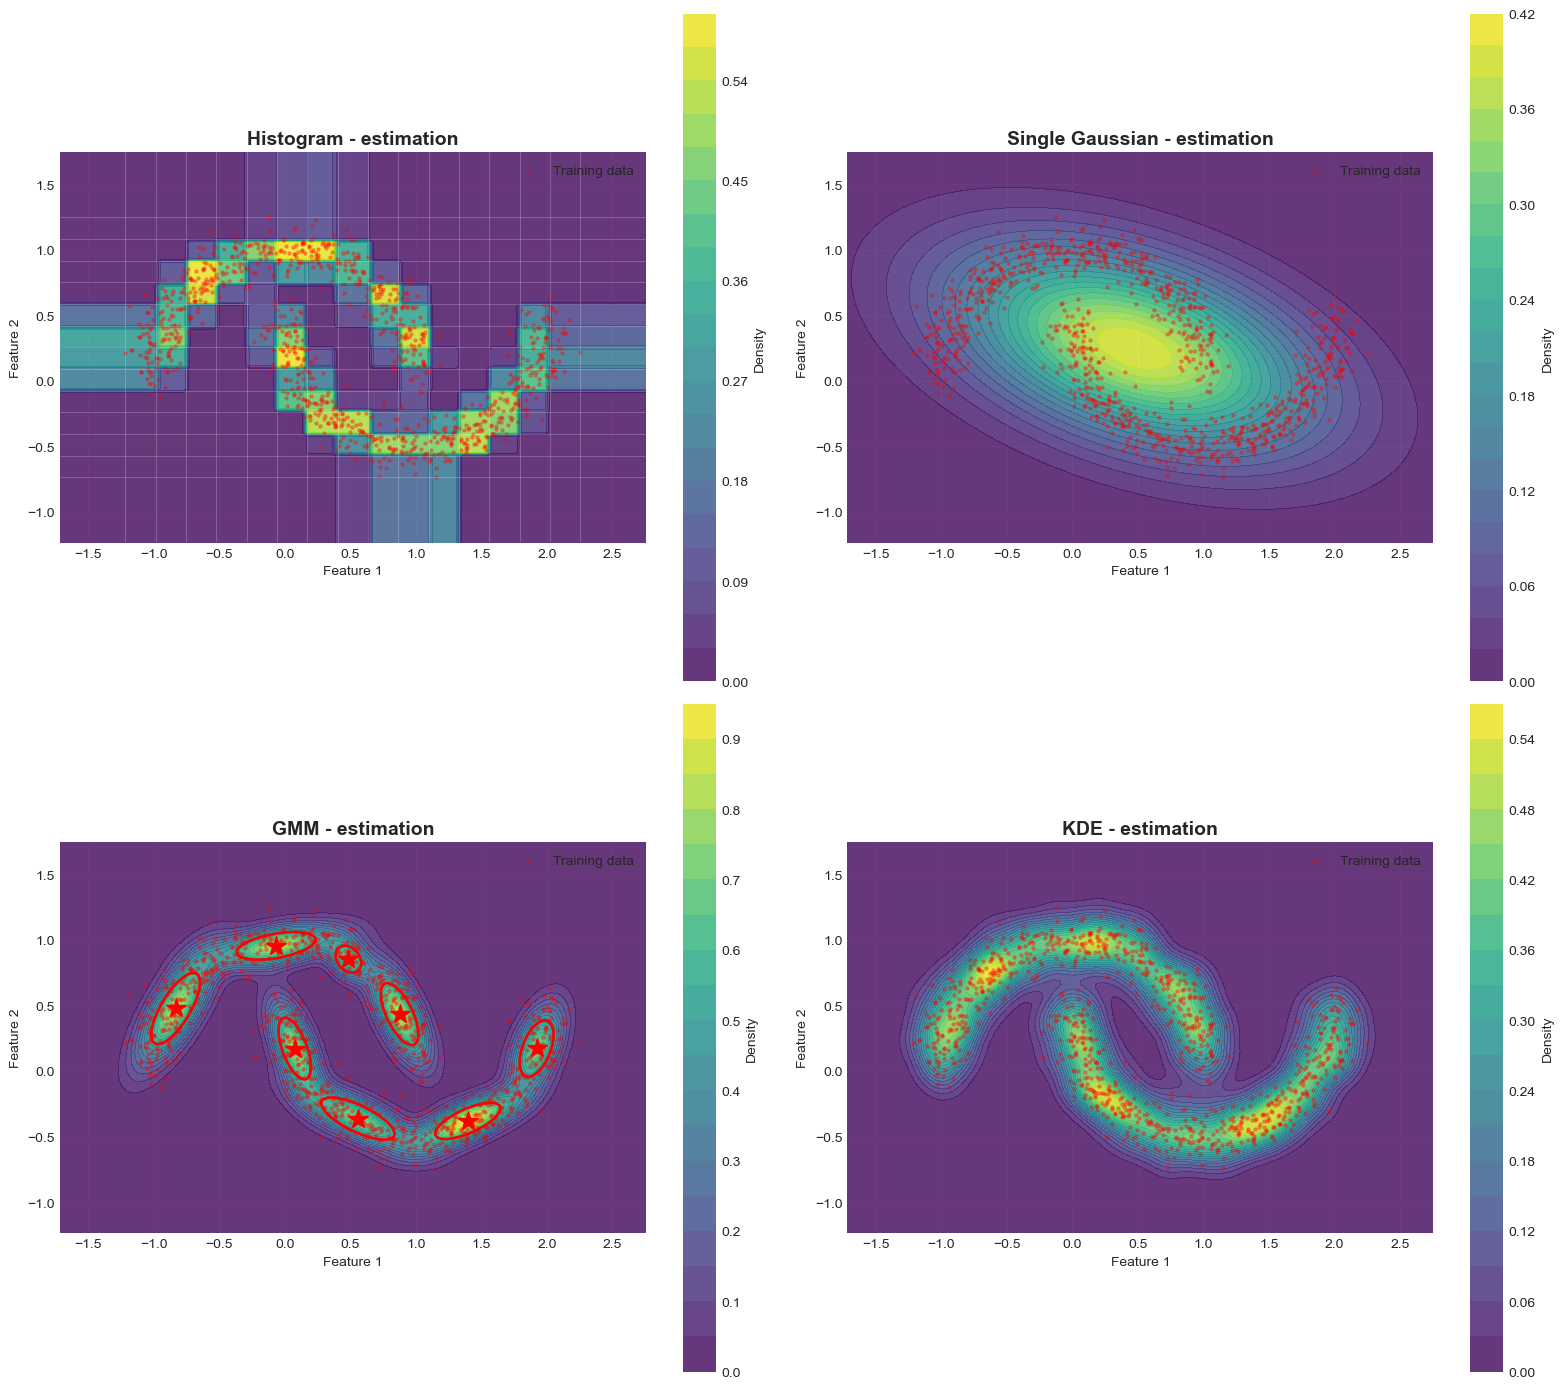

In [9]:
def plot_density(model, model_name, X_train, ax=None):
    """
    visualize density estimation results
    Parameters:
        model: density model
        model_name: model name
        X_train: training data
        ax: matplotlib axis object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # create grid
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # calculate densities
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    log_densities = model.score_samples(grid_points)
    densities = np.exp(log_densities).reshape(xx.shape)
    
    # plot density heatmap
    contour = ax.contourf(xx, yy, densities, levels=20, cmap='viridis', alpha=0.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c='red', s=5, alpha=0.3, label='Training data')

    # Add special markers
    if model_name == "Histogram" and hasattr(model, 'bins_x'):
        for edge in model.bins_x:
            ax.axvline(edge, color='white', alpha=0.3, linewidth=0.5)
        for edge in model.bins_y:
            ax.axhline(edge, color='white', alpha=0.3, linewidth=0.5)
    
    elif isinstance(model, GaussianMixtureModel) and hasattr(model, 'means'):
        # Show Gaussian components
        for k in range(model.n_components):
            # Compute eigenvalues and eigenvectors
            eigvals, eigvecs = np.linalg.eig(model.covs[k])
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)
            
            ellipse = Ellipse(model.means[k], width, height, angle=angle,
                            facecolor='none', edgecolor='red', linewidth=2)
            ax.add_patch(ellipse)
            ax.plot(model.means[k][0], model.means[k][1], 'r*', markersize=15)

    ax.set_title(f'{model_name} - estimation', fontsize=14, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    # plt.axis('equal')
    ax.legend()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')

    plt.colorbar(contour, ax=ax, label='Density')

    
    return ax

# Plot density estimation for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

models = [
    (hist_model, "Histogram"),
    (sg_model, "Single Gaussian"),
    (gmm_model, "GMM"),
    (kde_model, "KDE")
]

for i, (model, name) in enumerate(models):
    plot_density(model, name, X_train, ax=axes[i])

plt.tight_layout()
plt.show()

### 5.2 sample visualization

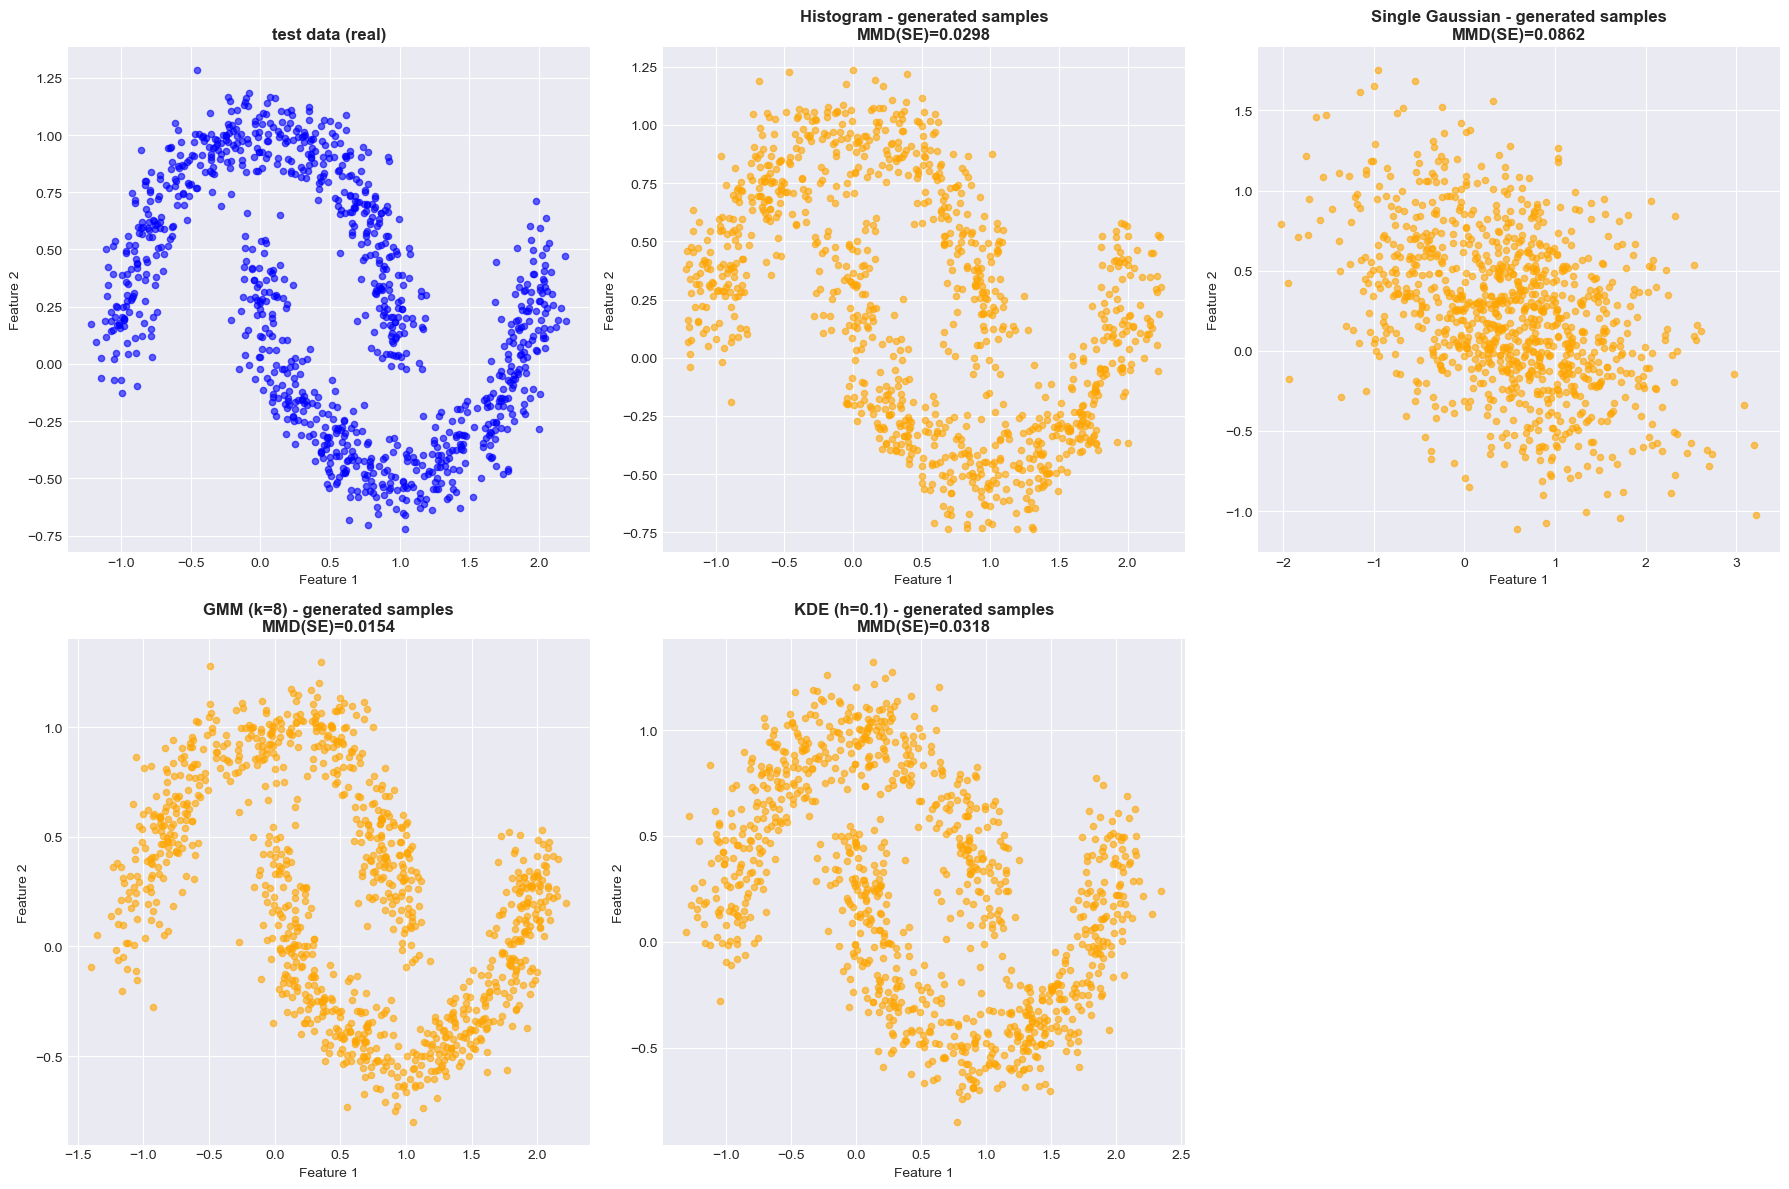

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# original test data
axes[0, 0].scatter(X_test[:, 0], X_test[:, 1], alpha=0.6, s=20, c='blue')
axes[0, 0].set_title('test data (real)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')

# samples generated by each model
for i, result in enumerate(results):
    row = (i + 1) // 3
    col = (i + 1) % 3
    
    X_gen = result['samples']
    axes[row, col].scatter(X_gen[:, 0], X_gen[:, 1], alpha=0.6, s=20, c='orange')
    axes[row, col].set_title(f"{result['model']} - generated samples\nMMD(SE)={result['mmd_se']:.4f}", 
                            fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Feature 1')
    axes[row, col].set_ylabel('Feature 2')

# hide unused subplots
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

### 6. Hyperparameter Influence Analysis

histogram - bin number effect:
Using fixed bin number: 5 x 5
  bins=5: MMD(SE)=0.0670, MMD(IMQ)=0.0828
Using fixed bin number: 10 x 10
  bins=10: MMD(SE)=0.0412, MMD(IMQ)=0.0340
Using fixed bin number: 20 x 20
  bins=20: MMD(SE)=0.0173, MMD(IMQ)=0.0121
Using fixed bin number: 30 x 30
  bins=30: MMD(SE)=0.0290, MMD(IMQ)=0.0294
Using fixed bin number: 50 x 50
  bins=50: MMD(SE)=0.0277, MMD(IMQ)=0.0287


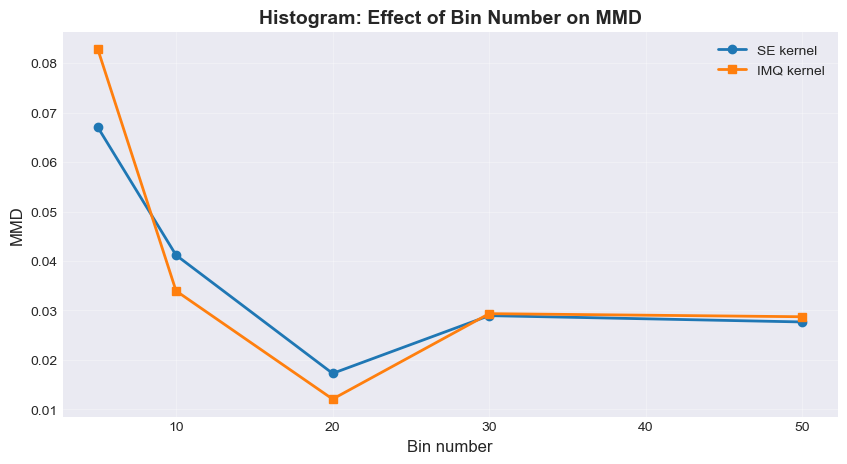

In [11]:
bin_sizes = [5, 10, 20, 30, 50]
mmd_results_hist = {'bins': [], 'mmd_se': [], 'mmd_imq': []}

print("histogram - bin number effect:")
for n_bins in bin_sizes:
    model = Histogram(n_bins=n_bins)
    model.fit(X_train)
    X_gen = model.sample(1000)

    mmd_se = compute_mmd(X_test, X_gen, kernel='se', h=0.1)
    mmd_imq = compute_mmd(X_test, X_gen, kernel='imq', h=0.1)

    mmd_results_hist['bins'].append(n_bins)
    mmd_results_hist['mmd_se'].append(mmd_se)
    mmd_results_hist['mmd_imq'].append(mmd_imq)

    print(f"  bins={n_bins}: MMD(SE)={mmd_se:.4f}, MMD(IMQ)={mmd_imq:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mmd_results_hist['bins'], mmd_results_hist['mmd_se'], 'o-', label='SE kernel', linewidth=2)
plt.plot(mmd_results_hist['bins'], mmd_results_hist['mmd_imq'], 's-', label='IMQ kernel', linewidth=2)
plt.xlabel('Bin number', fontsize=12)
plt.ylabel('MMD', fontsize=12)
plt.title('Histogram: Effect of Bin Number on MMD', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.2 GMM: The Influence of the Number of Components


GMM - effect of n_components:
GMM convergence at 97
  n_components=2: MMD(SE)=0.0779, MMD(IMQ)=0.1079
GMM convergence at 54
  n_components=3: MMD(SE)=0.0693, MMD(IMQ)=0.0880
GMM convergence at 52
  n_components=4: MMD(SE)=0.0549, MMD(IMQ)=0.0641
  n_components=5: MMD(SE)=0.0483, MMD(IMQ)=0.0552
  n_components=6: MMD(SE)=0.0353, MMD(IMQ)=0.0396
  n_components=8: MMD(SE)=0.0252, MMD(IMQ)=0.0348


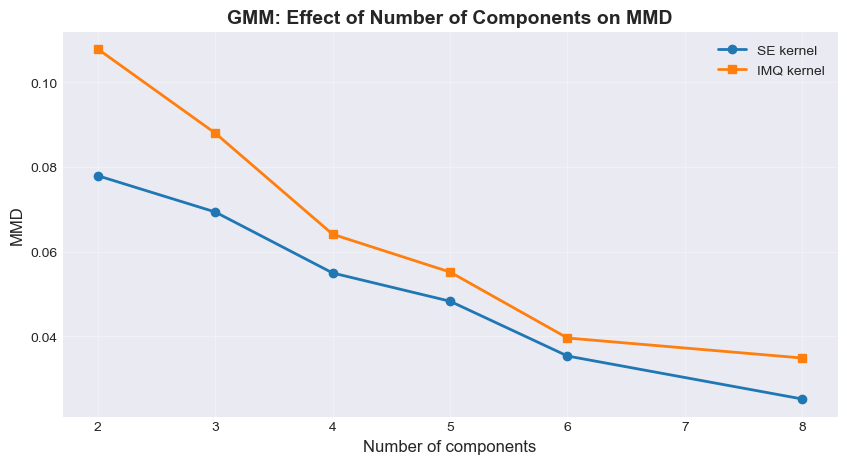

In [12]:
n_components_list = [2, 3, 4, 5, 6, 8]
mmd_results_gmm = {'n_components': [], 'mmd_se': [], 'mmd_imq': []}

print("\nGMM - effect of n_components:")
for n_comp in n_components_list:
    model = GaussianMixtureModel(n_components=n_comp, max_iter=100)
    model.fit(X_train)
    X_gen = model.sample(1000)

    mmd_se = compute_mmd(X_test, X_gen, kernel='se', h=0.1)
    mmd_imq = compute_mmd(X_test, X_gen, kernel='imq', h=0.1)

    mmd_results_gmm['n_components'].append(n_comp)
    mmd_results_gmm['mmd_se'].append(mmd_se)
    mmd_results_gmm['mmd_imq'].append(mmd_imq)

    print(f"  n_components={n_comp}: MMD(SE)={mmd_se:.4f}, MMD(IMQ)={mmd_imq:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mmd_results_gmm['n_components'], mmd_results_gmm['mmd_se'], 'o-', label='SE kernel', linewidth=2)
plt.plot(mmd_results_gmm['n_components'], mmd_results_gmm['mmd_imq'], 's-', label='IMQ kernel', linewidth=2)
plt.xlabel('Number of components', fontsize=12)
plt.ylabel('MMD', fontsize=12)
plt.title('GMM: Effect of Number of Components on MMD', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.3 KDE: The Impact of Bandwidth


KDE - effect of bandwidth:
  bandwidth=0.1: MMD(SE)=0.0194, MMD(IMQ)=0.0225
  bandwidth=0.2: MMD(SE)=0.0548, MMD(IMQ)=0.0588
  bandwidth=0.3: MMD(SE)=0.0696, MMD(IMQ)=0.0887
  bandwidth=0.5: MMD(SE)=0.0801, MMD(IMQ)=0.1137
  bandwidth=0.7: MMD(SE)=0.0863, MMD(IMQ)=0.1442
  bandwidth=1.0: MMD(SE)=0.0949, MMD(IMQ)=0.1763


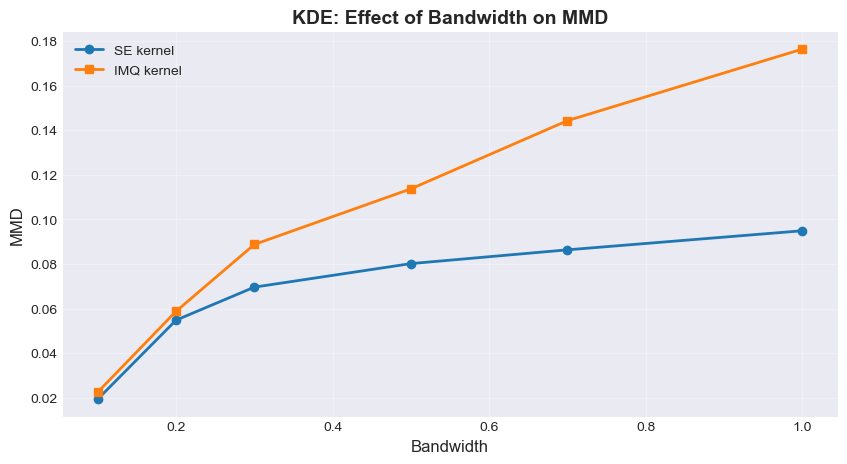

In [13]:
bandwidths = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
mmd_results_kde = {'bandwidth': [], 'mmd_se': [], 'mmd_imq': []}

print("\nKDE - effect of bandwidth:")
for bw in bandwidths:
    model = KernelDensityEstimator(bandwidth=bw)
    model.fit(X_train)
    X_gen = model.sample(1000)

    mmd_se = compute_mmd(X_test, X_gen, kernel='se', h=0.1)
    mmd_imq = compute_mmd(X_test, X_gen, kernel='imq', h=0.1)

    mmd_results_kde['bandwidth'].append(bw)
    mmd_results_kde['mmd_se'].append(mmd_se)
    mmd_results_kde['mmd_imq'].append(mmd_imq)

    print(f"  bandwidth={bw}: MMD(SE)={mmd_se:.4f}, MMD(IMQ)={mmd_imq:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mmd_results_kde['bandwidth'], mmd_results_kde['mmd_se'], 'o-', label='SE kernel', linewidth=2)
plt.plot(mmd_results_kde['bandwidth'], mmd_results_kde['mmd_imq'], 's-', label='IMQ kernel', linewidth=2)
plt.xlabel('Bandwidth', fontsize=12)
plt.ylabel('MMD', fontsize=12)
plt.title('KDE: Effect of Bandwidth on MMD', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.4 Impact of Training Set Size


effect of training set size:
Using fixed bin number: 20 x 20
  size=100: Hist=0.0659, Gauss=0.0847, GMM=0.0650, KDE=0.0729
Using fixed bin number: 20 x 20
  size=300: Hist=0.0381, Gauss=0.0900, GMM=0.0557, KDE=0.0689
Using fixed bin number: 20 x 20
  size=500: Hist=0.0206, Gauss=0.0875, GMM=0.0616, KDE=0.0720
Using fixed bin number: 20 x 20
  size=1000: Hist=0.0231, Gauss=0.0863, GMM=0.0703, KDE=0.0720
Using fixed bin number: 20 x 20
  size=2000: Hist=0.0113, Gauss=0.0873, GMM=0.0716, KDE=0.0697


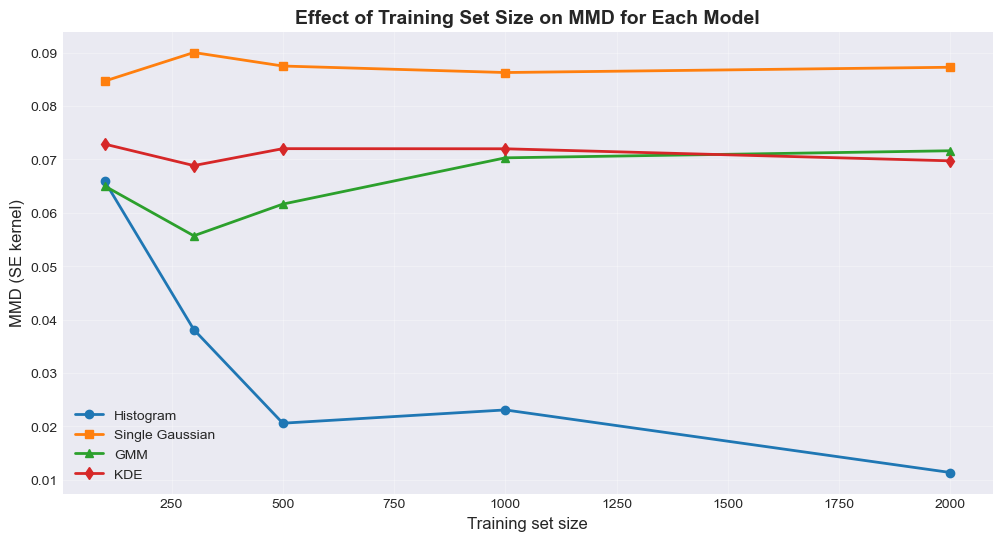

In [14]:
train_sizes = [100, 300, 500, 1000, 2000]
mmd_results_size = {
    'size': [],
    'hist_mmd': [], 'gaussian_mmd': [], 
    'gmm_mmd': [], 'kde_mmd': []
}

print("\neffect of training set size:")
for size in train_sizes:
    X_train_sub, _ = make_moons(n_samples=size, noise=0.1)

    # Histogram
    model_hist = Histogram(n_bins=20).fit(X_train_sub)
    mmd_hist = compute_mmd(X_test, model_hist.sample(1000), kernel='se', h=0.1)
    
    # single Gaussian
    model_gauss = SingleGaussian().fit(X_train_sub)
    mmd_gauss = compute_mmd(X_test, model_gauss.sample(1000), kernel='se', h=0.1)

    # GMM
    model_gmm = GaussianMixtureModel(n_components=4, max_iter=50).fit(X_train_sub)
    mmd_gmm = compute_mmd(X_test, model_gmm.sample(1000), kernel='se', h=0.1)

    # KDE
    model_kde = KernelDensityEstimator(bandwidth=0.3).fit(X_train_sub)
    mmd_kde = compute_mmd(X_test, model_kde.sample(1000), kernel='se', h=0.1)

    mmd_results_size['size'].append(size)
    mmd_results_size['hist_mmd'].append(mmd_hist)
    mmd_results_size['gaussian_mmd'].append(mmd_gauss)
    mmd_results_size['gmm_mmd'].append(mmd_gmm)
    mmd_results_size['kde_mmd'].append(mmd_kde)
    
    print(f"  size={size}: Hist={mmd_hist:.4f}, Gauss={mmd_gauss:.4f}, GMM={mmd_gmm:.4f}, KDE={mmd_kde:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(mmd_results_size['size'], mmd_results_size['hist_mmd'], 'o-', label='Histogram', linewidth=2)
plt.plot(mmd_results_size['size'], mmd_results_size['gaussian_mmd'], 's-', label='Single Gaussian', linewidth=2)
plt.plot(mmd_results_size['size'], mmd_results_size['gmm_mmd'], '^-', label='GMM', linewidth=2)
plt.plot(mmd_results_size['size'], mmd_results_size['kde_mmd'], 'd-', label='KDE', linewidth=2)
plt.xlabel('Training set size', fontsize=12)
plt.ylabel('MMD (SE kernel)', fontsize=12)
plt.title('Effect of Training Set Size on MMD for Each Model', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 2D Probability Density Estimation Models: An Analysis Summary

This project conducts a systematic analysis and comparison of four classic 2D probability density estimation models:

Histogram

Single Gaussian Model

Gaussian Mixture Model (GMM)

Kernel Density Estimation (KDE)

We used the make_moons dataset (noise=0.1) to train the models and employed the Maximum Mean Discrepancy (MMD) as the core evaluation metric. This metric quantifies the goodness-of-fit by comparing the data distribution generated by the model against the true test set.

### 1. Core Findings: Model Performance Comparison

The performance of each model is directly related to its ability to capture the complex bimodal structure of the make_moons dataset.

(1) Histogram:

The Histogram's performance was moderate. Its effectiveness is highly dependent on the "bin"  definition. While it roughly captured the two high-density regions, its estimated density is piecewise-constant (non-smooth) and constrained by the grid boundaries.

(2)Single Gaussian Model:

This model performed the worst. Because make_moons is a bimodal distribution, the Single Gaussian model—which can only model a single, symmetrical, elliptical distribution—was fundamentally unable to capture the true data structure.

(3) GMM :

GMM performed exceptionally well. By using multiple Gaussian components (Here we choose K=2,3,4,5,6,8), it was able to effectively approximate the bimodal distribution, achieving results close to KDE.

(4) KDE :

As a flexible non-parametric method, KDE performed the best. It successfully fit the two crescent shapes of the data, providing a smooth and accurate density estimate.


### 2. Analysis of Key Influencing Factors

#### 2.1 Hyperparameter Sensitivity

The performance of all models is highly dependent on their key hyperparameters.

(1)Histogram 

Number of Bins:

Too few bins (5x5) → Underfitting, resulting in a very coarse density map.

Too many bins (50x50) → Overfitting, which paradoxically increased the MMD score.

The automated FD (Freedman-Diaconis) rule or a bin count of 15-25 performed well on this dataset.


(2)GMM:

Number of Components K:
When K=1, the model degenerates into a Single Gaussian.

At K=6 or K=8, the MMD score was lowest, striking the best balance between complexity and fit.

(3)KDE:

Bandwidth h: This was the most sensitive parameter. The bandwidth h controls the degree of smoothing.

h too small  → Overfitting, resulting in a spiky density map and a high MMD score.

h too large  → Underfitting, resulting in an over-smoothed density that lost the bimodal structure.

The optimal range (h ≈ 0.1 - 0.3) performed best.




#### 2.2 Impact of Training Set Size

GMM and KDE demonstrated clear convergence: their MMD scores monotonically decreased as the sample size (n) increased. This confirms they are effective at utilizing larger datasets to improve their distributional estimates, with KDE showing the best asymptotic performance by surpassing GMM at n > 1000；The Histogram model, in contrast, exhibited non-monotonic behavior. Its performance improved for n < 1000 but then degraded as n increased. This is attributed to overfitting: the Freedman-Diaconis (FD) rule, where bin width $h$ is proportional to $n^{-1/3}$, automatically creates an excessive number of smaller bins at high n. This causes the model to capture sample-specific noise rather than the true underlying density, which is correctly penalized by the MLD metric.

### 3. A Note on MMD and Kernel Choice

The MMD metric measures the distance between two distributions ($P_{data}$ and $P_{model}$) in a Reproducing Kernel Hilbert Space (RKHS). A lower MMD score indicates that the two distributions are more similar.

The choice of kernel $k(x, y)$ defines the RKHS and is critical, as it determines which differences between distributions are emphasized. This analysis uses two distinct kernels for a more robust evaluation:

**Squared Exponential (SE) Kernel:** $k(x, y) = \exp(-\|x - y\|^2 / h^2)$


**Characteristic:** This is a local kernel. Its influence decays exponentially with distance.

**Sensitivity:** It is highly sensitive to local, high-frequency differences—such as the precise shape, curvature, and separation of the high-density "moons." A poor fit in the modes of the distribution (the main shapes) will be heavily penalized by the SE kernel.

**Inverse Multi-Quadratic (IMQ) Kernel:** $k(x, y) = 1 / \sqrt{1 + \|x - y\|^2 / h^2}$


**Characteristic:** This is a global, heavy-tailed kernel. Its influence decays polynomially, much slower than the SE kernel.

**Sensitivity:** It is more sensitive to global, low-frequency differences. It places more weight on points that are far apart, making it effective at detecting differences in the tails of the distributions or spotting spurious outliers generated far from the true data.

**Conclusion:** Using both kernels provides a more complete picture. The SE (RBF) kernel ensures the model accurately captures the local shape of the moons, while the IMQ kernel ensures the model captures the global spread and does not generate unrealistic outliers.

### 4. Conclusions and Recommendations

**Final Conclusions**

There is no "one-size-fits-all" model: Model selection depends on the data's intrinsic structure, the sample size, and the computational budget.

Weighing the Trade-offs:


For complex, irregular distributions like `make_moons`, **KDE** provides the highest fitting accuracy.

**GMM** provides (slightly lower) high accuracy while also offering faster sampling and some interpretability (the K components can be viewed as "clusters").

**Hyperparameters are Critical:** For GMM and KDE, careful tuning of hyperparameters (K and h) using methods like cross-validation is essential for achieving good performance.

**Recommendations for the `make_moons` Dataset**

**For Maximum Accuracy:** Use **KDE** and carefully tune the bandwidth `h` (e.g., **h ≈ 0.3**).

**For Speed and Clustering:** Use **GMM** and select an appropriate `K` (e.g., **K=8**).

# High-Dimensional Density Estimation - Digits Dataset
Use 4 density estimation models: DensityForest, Single Gaussian, GMM, KDE

Calculate MMD² (SE and IMQ kernels)

Visualize the generated digits

Use RandomForest to evaluate recognizability

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.spatial.distance import pdist


from density_forest import DensityForest

## 1. MMD² Function

In [2]:
def rbf_kernel(X, Y, gamma=None):
    """SE kernel: k(x,y) = exp(-gamma * ||x-y||²)"""
    if gamma is None:
        gamma = 1.0 / (2 * X.shape[1])
    
    XX = np.sum(X**2, axis=1).reshape(-1, 1)
    YY = np.sum(Y**2, axis=1).reshape(1, -1)
    XY = X @ Y.T
    
    distances_sq = np.maximum(XX - 2*XY + YY, 0)
    return np.exp(-gamma * distances_sq)


def imq_kernel(X, Y, c=1.0, beta=0.5):
    """IMQ kernel: k(x,y) = (c² + ||x-y||²)^(-beta)"""
    XX = np.sum(X**2, axis=1).reshape(-1, 1)
    YY = np.sum(Y**2, axis=1).reshape(1, -1)
    XY = X @ Y.T
    
    distances_sq = np.maximum(XX - 2*XY + YY, 0)
    return np.power(c**2 + distances_sq, -beta)


def compute_mmd_squared(X, Y, kernel_type='rbf', **kernel_params):
    """compute MMD² Maximum Mean Discrepancy"""
    if kernel_type == 'rbf':
        K_XX = rbf_kernel(X, X, **kernel_params)
        K_YY = rbf_kernel(Y, Y, **kernel_params)
        K_XY = rbf_kernel(X, Y, **kernel_params)
    elif kernel_type == 'imq':
        K_XX = imq_kernel(X, X, **kernel_params)
        K_YY = imq_kernel(Y, Y, **kernel_params)
        K_XY = imq_kernel(X, Y, **kernel_params)
    
    n, m = K_XX.shape[0], K_YY.shape[0]

    # Unbiased estimate: exclude diagonal
    term1 = (K_XX.sum() - np.trace(K_XX)) / (n * (n - 1))
    term2 = (K_YY.sum() - np.trace(K_YY)) / (m * (m - 1))
    term3 = K_XY.mean()
    
    return term1 + term2 - 2 * term3

## 2. Visualizing Functions

In [3]:
def visualize_digits_grid(samples, title="Generated Digits", n_rows=4, n_cols=10, figsize=(15, 6)):
    """
    generate a grid of digit images from samples
    """
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    for i in range(n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        
        if i < len(samples):
            digit = samples[i].reshape(8, 8)
            digit = np.clip(digit, 0, 16)
            axes[row, col].imshow(digit, cmap='gray_r', vmin=0, vmax=16)
        
        axes[row, col].axis('off')
    
    plt.suptitle(title, fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()





def plot_distribution_comparison(y_real, generated_samples, clf, model_name):
    """compare the class distribution of real and generated data"""
    predictions = clf.predict(generated_samples)
    
    real_dist = Counter(y_real)
    gen_dist = Counter(predictions)
    
    digits = range(10)
    real_counts = [real_dist.get(d, 0) for d in digits]
    gen_counts = [gen_dist.get(d, 0) for d in digits]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    x = np.arange(len(digits))
    width = 0.35
    
    ax.bar(x - width/2, real_counts, width, label='Real', color='skyblue', alpha=0.8)
    ax.bar(x + width/2, gen_counts, width, label='Generated', color='salmon', alpha=0.8)
    
    ax.set_xlabel('Digit Class', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'Class Distribution Comparison - {model_name}', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(digits)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 3. Loading Data

In [4]:
print("Loading Digits Dataset...")
digits = load_digits()
X = digits.data
y = digits.target

print(f"Dataset shape: {X.shape}")
print(f"Features: {X.shape[1]}D")
print(f"Samples: {X.shape[0]}")
print(f"Classes: {len(np.unique(y))}")
print(f"Value range: [{X.min():.1f}, {X.max():.1f}]\n")

Loading Digits Dataset...
Dataset shape: (1797, 64)
Features: 64D
Samples: 1797
Classes: 10
Value range: [0.0, 16.0]



Real data samples:


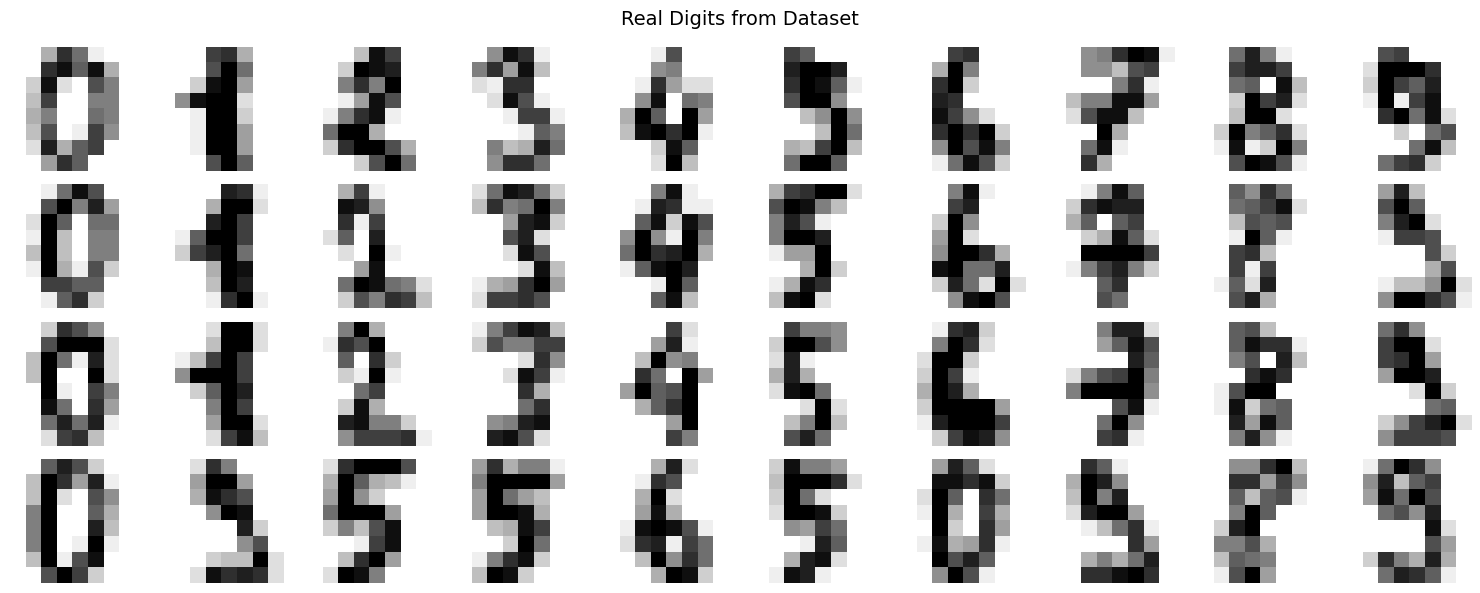

In [5]:
# visualize some real data samples
print("Real data samples:")
visualize_digits_grid(X[:40], title="Real Digits from Dataset", n_rows=4, n_cols=10)

## 4. Define the density estimation model

In [6]:
models = {}

print("Initializing models...\n")

# 1. DensityForest
models['DensityForest'] = DensityForest(n_trees=50, n_min=10)
print("✓ DensityForest (n_trees=50, n_min=10)")

# 2. Single Gaussian
models['Single_Gaussian'] = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
print("✓ Single Gaussian (n_components=1)")

# 3. GMM
models['GMM_K16'] = GaussianMixture(n_components=16, covariance_type='full', random_state=42, max_iter=200)
print("✓ GMM (n_components=16)")

# 4. KDE
models['KDE'] = KernelDensity(bandwidth=1.0, kernel='gaussian')
print("✓ KDE (bandwidth=1.0)")

print(f"\nTotal models: {len(models)}")

Initializing models...

✓ DensityForest (n_trees=50, n_min=10)
✓ Single Gaussian (n_components=1)
✓ GMM (n_components=16)
✓ KDE (bandwidth=1.0)

Total models: 4


## 5. Train the model and generate samples

In [7]:
generated_samples = {}
n_samples = 500 # number of samples to generate

for name, model in models.items():
    print(f"\n[{name}]")
    print("  Training...", end=" ")
    model.fit(X)
    print("Done")
    
    print("  Generating samples...", end=" ")
    if name == 'DensityForest':
        generated = model.sample(n_samples=n_samples)
    elif name == 'KDE':
        generated = model.sample(n_samples=n_samples)
    else:
        generated, _ = model.sample(n_samples=n_samples)
    
    generated_samples[name] = generated
    print(f"Done (shape: {generated.shape})")

print("\n✓ All models trained and samples generated")


[DensityForest]
  Training... Done
  Generating samples... Done (shape: (500, 64))

[Single_Gaussian]
  Training... Done
  Generating samples... Done (shape: (500, 64))

[GMM_K16]
  Training... Done
  Generating samples... Done (shape: (500, 64))

[KDE]
  Training... Done
  Generating samples... Done (shape: (500, 64))

✓ All models trained and samples generated


## 6. Calculate MMD²


In [8]:
print("Computing kernel parameters...")

# gamma using median heuristic
sample_size = min(500, len(X))
X_sample = X[np.random.choice(len(X), sample_size, replace=False)]
#use scipy's pdist to compute pairwise distances
distances = pdist(X_sample, 'euclidean') 

median_dist = np.median(distances)
gamma_rbf = 1.0 / (2 * median_dist**2) if median_dist > 0 else 1.0 / (2 * X.shape[1])

print(f"RBF kernel gamma: {gamma_rbf:.6f}")
print(f"IMQ kernel params: c=1.0, beta=0.5\n")

results = {}

print("Computing MMD² for each model:\n")
for name, generated in generated_samples.items():
    mmd_se = compute_mmd_squared(X, generated, kernel_type='rbf', gamma=gamma_rbf)
    mmd_imq = compute_mmd_squared(X, generated, kernel_type='imq', c=1.0, beta=0.5)
    
    results[name] = {'mmd_se': mmd_se, 'mmd_imq': mmd_imq}
    
    print(f"{name:20s}  SE: {mmd_se:.6f}  IMQ: {mmd_imq:.6f}")

print("\n✓ MMD² computation complete")

Computing kernel parameters...
RBF kernel gamma: 0.000208
IMQ kernel params: c=1.0, beta=0.5

Computing MMD² for each model:

DensityForest         SE: -0.000041  IMQ: 0.000027
Single_Gaussian       SE: -0.000251  IMQ: 0.000250
GMM_K16               SE: 0.000170  IMQ: 0.000031
KDE                   SE: 0.000038  IMQ: -0.000045

✓ MMD² computation complete


## 7. Visualizing the generated numbers


DensityForest:


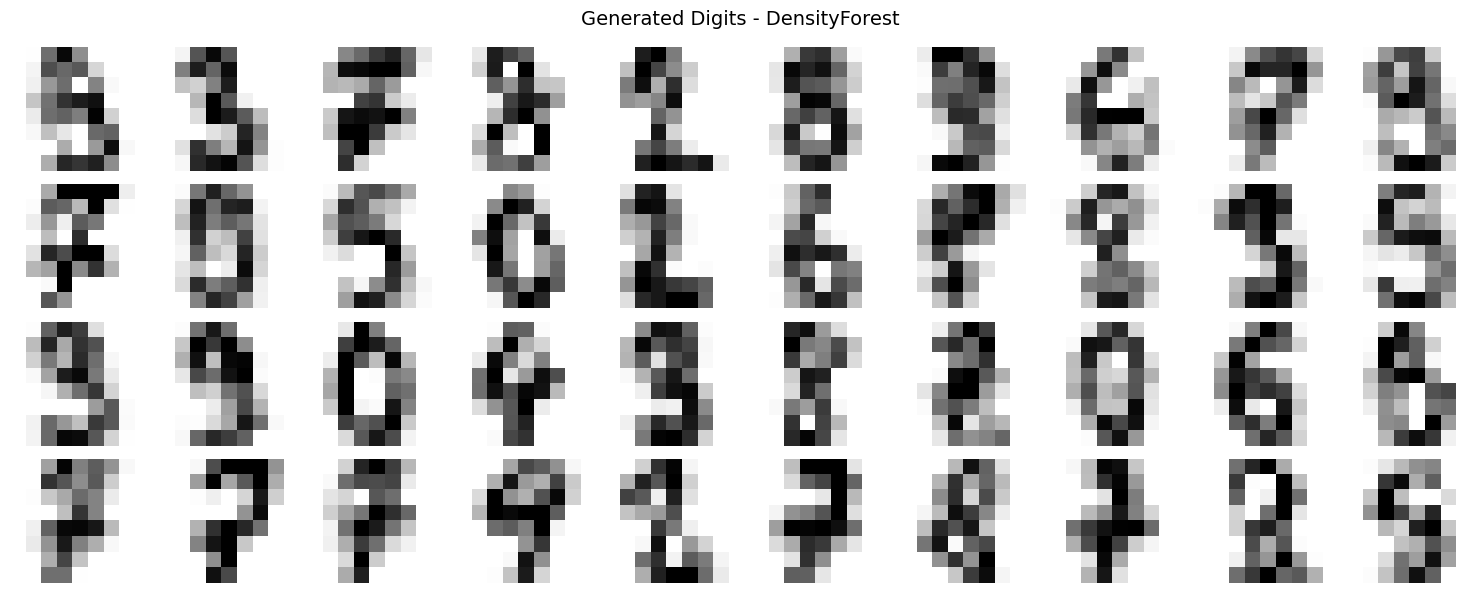


Single_Gaussian:


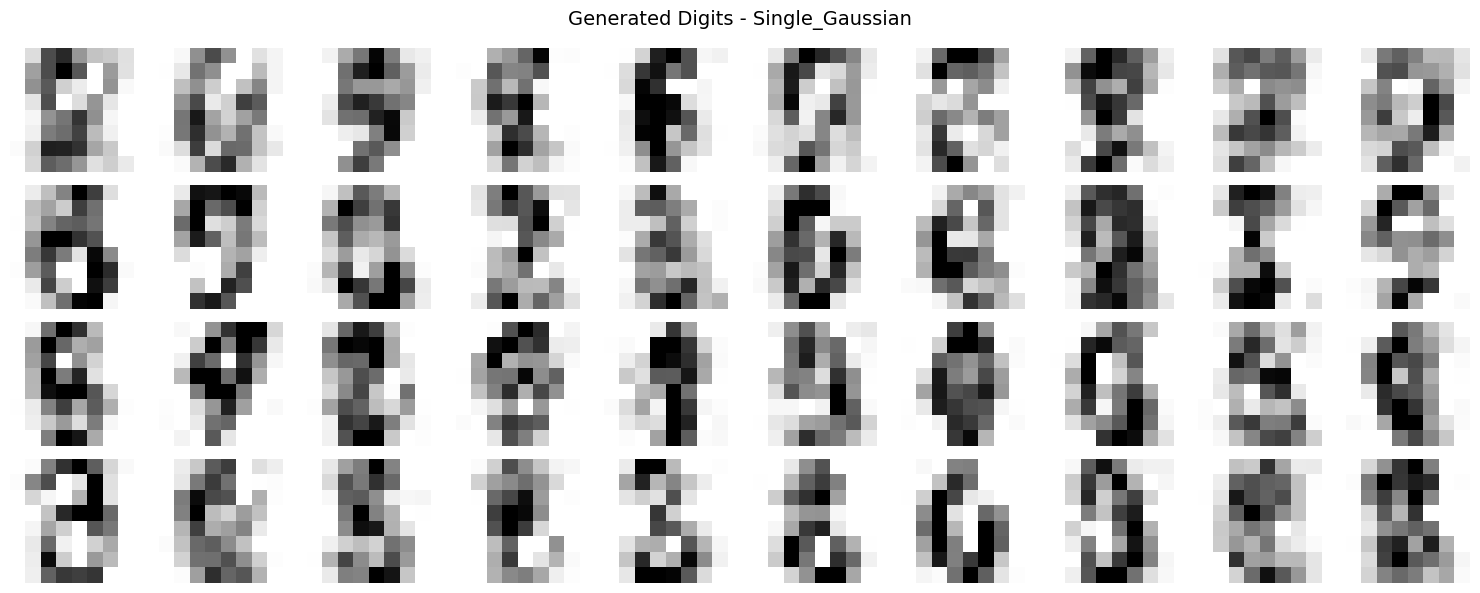


GMM_K16:


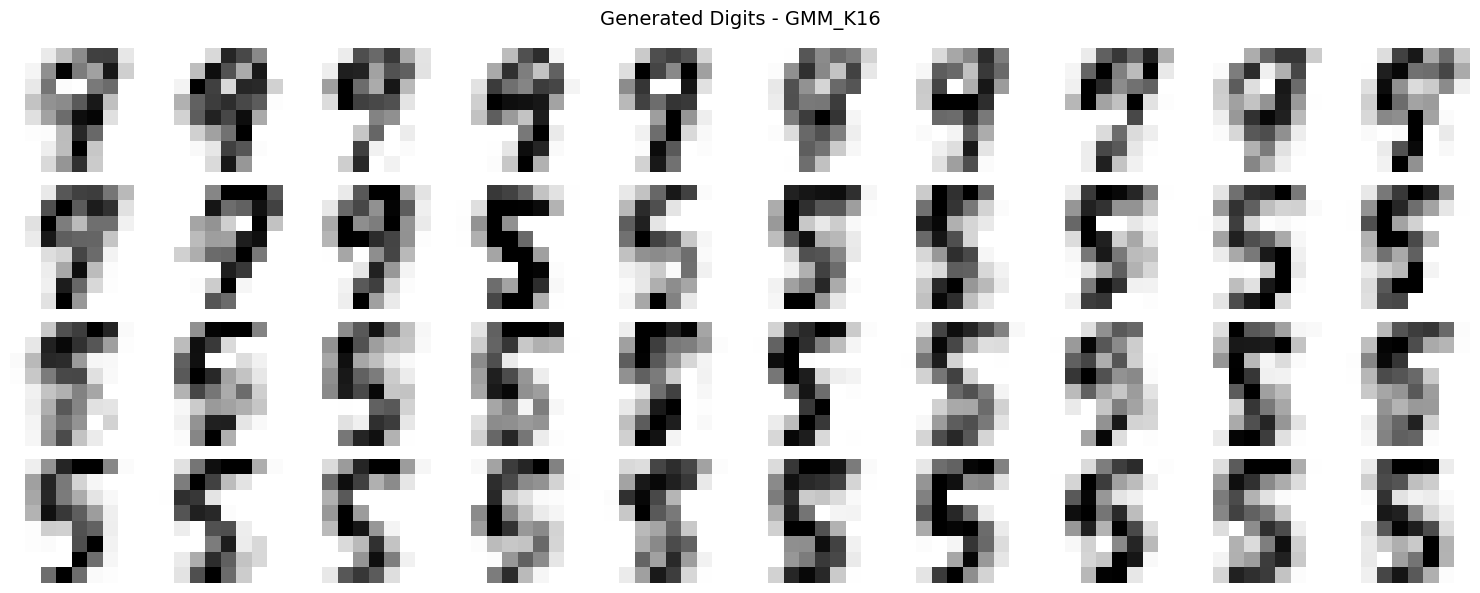


KDE:


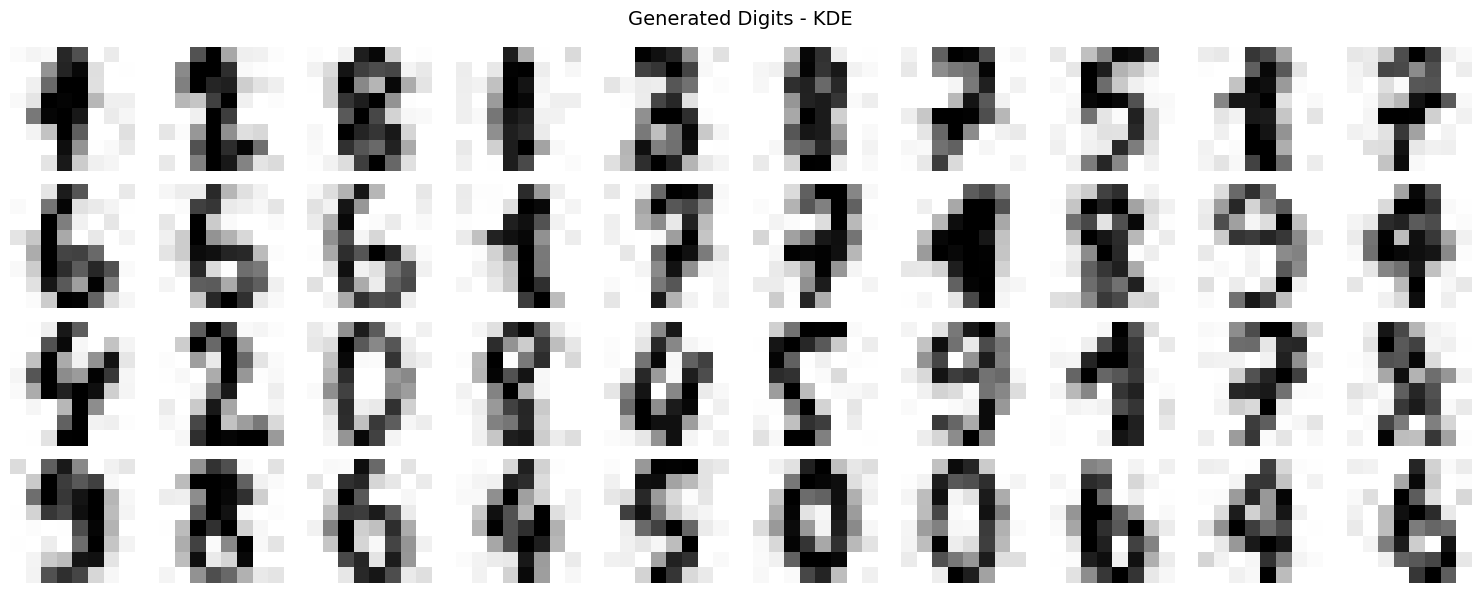

In [9]:
# visualize generated samples
for name, generated in generated_samples.items():
    print(f"\n{name}:")
    visualize_digits_grid(generated[:40], title=f"Generated Digits - {name}", n_rows=4, n_cols=10)

## 8. Identifiability check（RandomForest）

In [10]:
print("Training RandomForestClassifier...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(f"Classifier accuracy - Train: {train_acc:.4f}, Test: {test_acc:.4f}\n")
print("Evaluating generated samples...\n")

Training RandomForestClassifier...
Classifier accuracy - Train: 1.0000, Test: 0.9611

Evaluating generated samples...



In [11]:
# evaluate generated samples
for name, generated in generated_samples.items():
    print(f"\n{'='*60}")
    print(f"{name}")
 
    
    # predict
    pred_labels = clf.predict(generated)
    pred_proba = clf.predict_proba(generated)
    
    # display class distribution
    class_dist = Counter(pred_labels)
    print("\nClass distribution:")
    for digit in range(10):
        count = class_dist.get(digit, 0)
        percentage = count / len(generated) * 100
        bar = '█' * int(percentage / 2)
        print(f"  {digit}: {count:4d} ({percentage:5.1f}%) {bar}")

    # compute metrics
    expected_count = len(generated) / 10
    std_dev = np.std(list(class_dist.values()))
    uniformity = max(0, 1 - (std_dev / expected_count))
    
    max_proba = pred_proba.max(axis=1)
    avg_confidence = max_proba.mean()
    
    recognizability = (uniformity + avg_confidence) / 2
    
    print(f"\nMetrics:")
    print(f"  Uniformity:       {uniformity:.4f}")
    print(f"  Avg Confidence:   {avg_confidence:.4f}")
    print(f"  Recognizability:  {recognizability:.4f}")
    
    results[name]['recognizability'] = recognizability
    results[name]['uniformity'] = uniformity
    results[name]['confidence'] = avg_confidence




DensityForest

Class distribution:
  0:   42 (  8.4%) ████
  1:   33 (  6.6%) ███
  2:   56 ( 11.2%) █████
  3:   49 (  9.8%) ████
  4:   63 ( 12.6%) ██████
  5:   42 (  8.4%) ████
  6:   35 (  7.0%) ███
  7:   71 ( 14.2%) ███████
  8:   60 ( 12.0%) ██████
  9:   49 (  9.8%) ████

Metrics:
  Uniformity:       0.7642
  Avg Confidence:   0.6493
  Recognizability:  0.7068

Single_Gaussian

Class distribution:
  0:   27 (  5.4%) ██
  1:   20 (  4.0%) ██
  2:   57 ( 11.4%) █████
  3:   40 (  8.0%) ████
  4:   70 ( 14.0%) ███████
  5:   33 (  6.6%) ███
  6:   40 (  8.0%) ████
  7:   48 (  9.6%) ████
  8:   99 ( 19.8%) █████████
  9:   66 ( 13.2%) ██████

Metrics:
  Uniformity:       0.5515
  Avg Confidence:   0.3459
  Recognizability:  0.4487

GMM_K16

Class distribution:
  0:   60 ( 12.0%) ██████
  1:   39 (  7.8%) ███
  2:   37 (  7.4%) ███
  3:   47 (  9.4%) ████
  4:   49 (  9.8%) ████
  5:   51 ( 10.2%) █████
  6:   53 ( 10.6%) █████
  7:   57 ( 11.4%) █████
  8:   52 ( 10.4%) █████
  

## 9. Comparison of Category Distribution

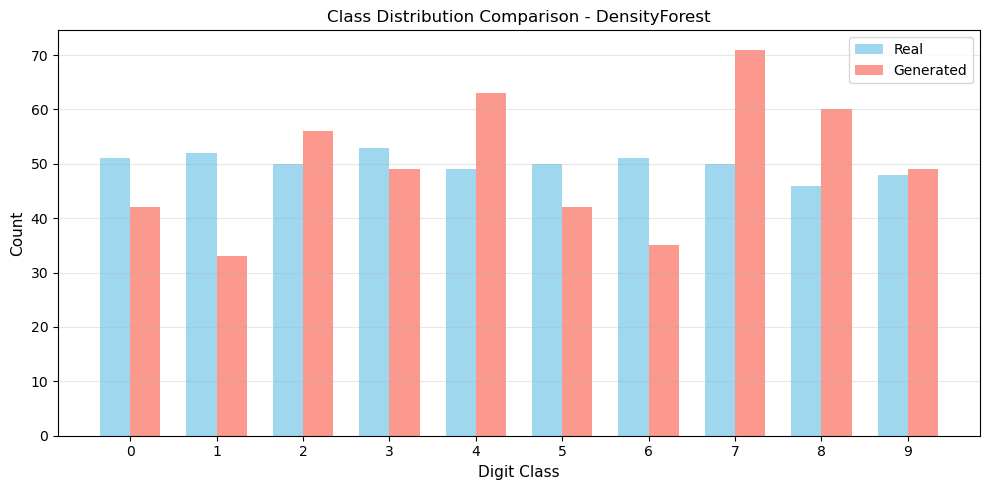

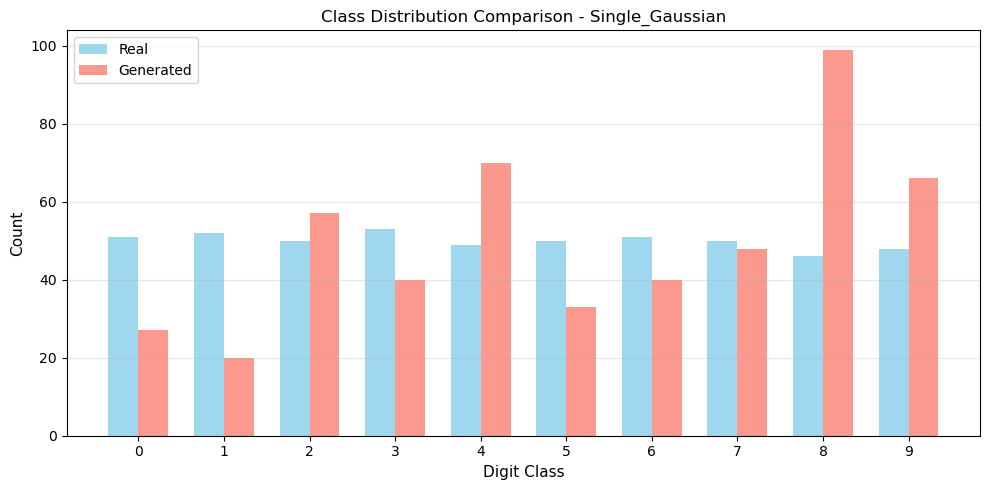

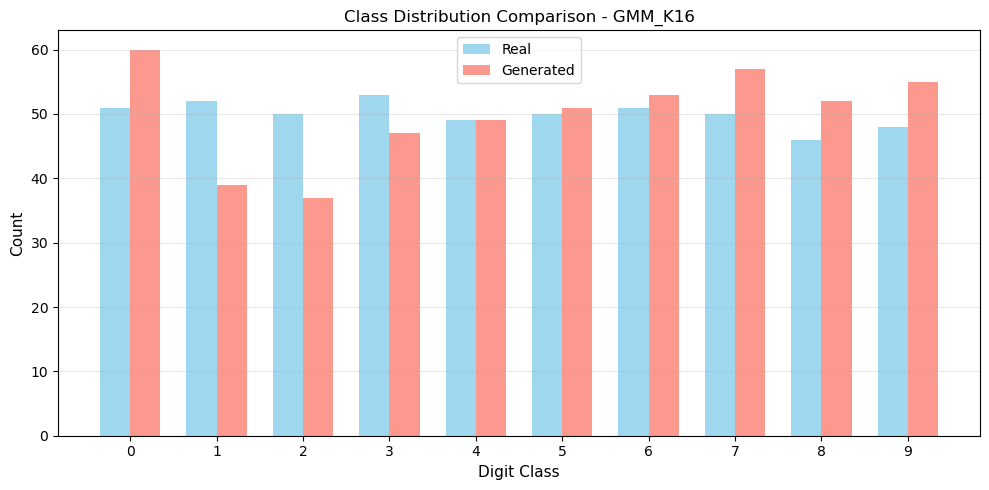

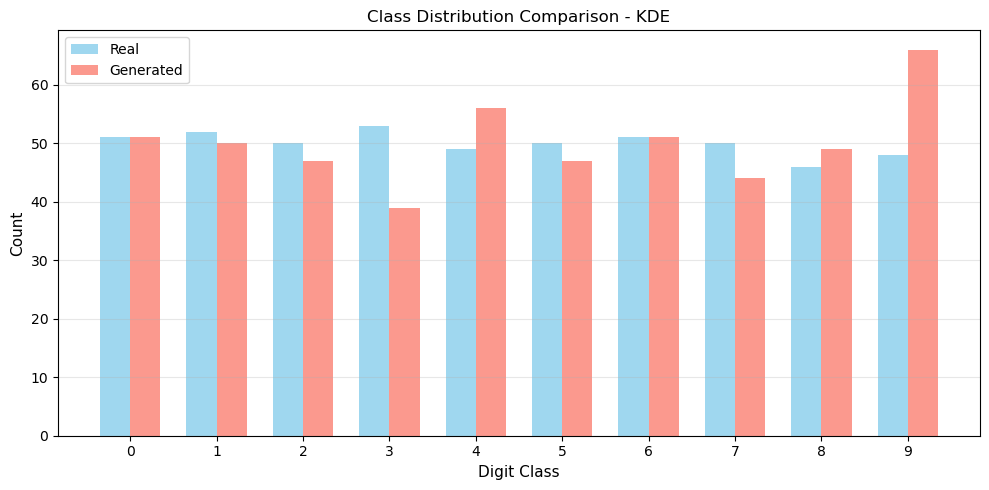

In [12]:
# visualize class distribution comparison

y_sample = y[:500]
for name, generated in generated_samples.items():
    plot_distribution_comparison(y_sample, generated, clf, name)

## 10. Summary and Conclusion

In [13]:


# summarize results
print(f"\n{'Model':<20} {'MMD²(SE)':<12} {'MMD²(IMQ)':<12} {'Recogniz.':<12} {'Uniform.':<12} {'Confid.':<12}")
print("-"*80)

for name in models.keys():
    r = results[name]
    print(f"{name:<20} {r['mmd_se']:<12.6f} {r['mmd_imq']:<12.6f} {r['recognizability']:<12.4f} {r['uniformity']:<12.4f} {r['confidence']:<12.4f}")

print("\n" + "="*80)

# find best models
best_mmd_se = min(results.items(), key=lambda x: x[1]['mmd_se'])
best_mmd_imq = min(results.items(), key=lambda x: x[1]['mmd_imq'])
best_recog = max(results.items(), key=lambda x: x[1]['recognizability'])

print("\nBest Models:")
print(f"  Lowest MMD² (SE):    {best_mmd_se[0]} ({best_mmd_se[1]['mmd_se']:.6f})")
print(f"  Lowest MMD² (IMQ):   {best_mmd_imq[0]} ({best_mmd_imq[1]['mmd_imq']:.6f})")
print(f"  Highest Recognizability: {best_recog[0]} ({best_recog[1]['recognizability']:.4f})")

print("\n" + "="*80)


Model                MMD²(SE)     MMD²(IMQ)    Recogniz.    Uniform.     Confid.     
--------------------------------------------------------------------------------
DensityForest        -0.000041    0.000027     0.7068       0.7642       0.6493      
Single_Gaussian      -0.000251    0.000250     0.4487       0.5515       0.3459      
GMM_K16              0.000170     0.000031     0.7780       0.8603       0.6958      
KDE                  0.000038     -0.000045    0.7760       0.8629       0.6891      


Best Models:
  Lowest MMD² (SE):    Single_Gaussian (-0.000251)
  Lowest MMD² (IMQ):   KDE (-0.000045)
  Highest Recognizability: GMM_K16 (0.7780)



### **Evaluation Metrics**

#### 1. MMD² 

**Purpose:** Quantitatively measures the statistical difference between the **generated data distribution** ($P_{model}$) and the **real data distribution** ($P_{data}$) in a Reproducing Kernel Hilbert Space (RKHS).

**Interpretation:** **A lower score is better** (a score of 0 indicates identical distributions).

**Implementation:** This analysis uses two distinct kernels for a robust, multi-faceted evaluation:

**SE  Kernel:**
        $k(x, y) = \exp(-\gamma \cdot \|x - y\|^2)$
        This is a "local" kernel, highly sensitive to high-frequency differences (e.g., the precise local shape and fine-grained texture of the digits).
        
**IMQ  Kernel:**
        $k(x, y) = (c^2 + \|x - y\|^2)^{-\beta}$
        This is a "global," heavy-tailed kernel. It is more sensitive to low-frequency differences, such as the overall spread of the data and the presence of unrealistic outliers.

#### 2. Recognizability Score (A Composite Metric)

**Purpose:** A composite metric designed to evaluate the "quality" and "diversity" of the generated digits, defined as the **average** of its two components:
    `Recognizability = (Uniformity + Confidence) / 2`
    
**Interpretation:** **A higher score is better** (max 1.0). A high score indicates the model generates digits that achieve a good **balance** between high confidence and high uniformity.

**Process:**
    1.  A Random Forest Classifier is trained on the **real** Digits dataset.
    2.  This pre-trained classifier is then used to predict the labels and probabilities of the **generated** (sampled) digits.

**Sub-Metric 1: Uniformity**
    **Measures:** The diversity of the generated samples.
    **Interpretation:** Checks if the classifier's *predicted labels* for the generated set are balanced across all 10 classes (0-9). A score near 1.0 means all digit classes were generated in equal measure.

**Sub-Metric 2: Confidence**
    **Measures:** The quality or clarity of the generated samples.
    * **Interpretation:** Calculated as the mean of the maximum probabilities (`predict_proba`) from the classifier. High confidence implies the generated digits are distinct, unambiguous, and closely resemble the features the classifier learned from real data.